<a href="https://colab.research.google.com/github/CalebFikes/FHAI/blob/main/DDPM_Random_Forest.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
# Install necessary packages (if using Colab)
%pip install umap-learn
%pip install -U kaleido

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 90.9/90.9 kB 697.9 kB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.8/55.8 kB 3.6 MB/s eta 0:00:00
  Created wheel for umap-learn: filename=umap_learn-0.5.5-py3-none-any.whl size=86832 sha256=d1b9c452bfa7cbf7355d8315d0969ea1d44ea7049e5b2f56fd78c780693f52fe
  Stored in directory: /root/.cache/pip/wheels/3a/70/07/428d2b58660a1a3b431db59b806a10da736612ebbc66c1bcc5
Successfully built umap-learn
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.9/79.9 MB 9.1 MB/s eta 0:00:00


In [3]:
# Only run this cell if using colab
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
'''
This script does conditional image generation on Patient Treatment Classification dataset (https://www.kaggle.com/datasets/saurabhshahane/patient-treatment-classification),
using a diffusion model

This code is modified from,
https://github.com/cloneofsimo/minDiffusion

Diffusion model is based on DDPM,
https://arxiv.org/abs/2006.11239

The conditioning idea is taken from 'Classifier-Free Diffusion Guidance',
https://arxiv.org/abs/2207.12598

This technique also features in ImageGen 'Photorealistic Text-to-Image Diffusion Models with Deep Language Understanding',
https://arxiv.org/abs/2205.11487

'''

from tensorboard import notebook
from typing import Dict, Tuple
import matplotlib.pyplot as plt
from tqdm import tqdm
import time
import torch
import torch.version
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torch.optim.lr_scheduler import StepLR
import matplotlib.pyplot as pltfrom
from itertools import combinations
from scipy.spatial import ConvexHull
import numpy as np
import copy
import torchvision
import random
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from torch.utils.data import Dataset
from sklearn.metrics import f1_score, roc_auc_score, accuracy_score,roc_curve
from umap import UMAP
import plotly.express as px
from itertools import product
import numpy as np
import torch
from torch.optim.lr_scheduler import StepLR
from IPython.core.display import deepcopy
from torch.utils.tensorboard import SummaryWriter
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import roc_auc_score, f1_score, roc_curve, ConfusionMatrixDisplay,auc
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde
torch.manual_seed(8675309)
random.seed(8675309)


In [5]:
class MyDataset(Dataset):
    '''
    Custom torch dataset.
    '''
    def __init__(self, x, s, y):
        '''
        Initialize the MyDataset.

        Args:
            x (pd.DataFrame): Input data.
            y (pd.DataFrame): Target data.
        '''
        self.x =torch.tensor(x.values,dtype=torch.float32)
        self.s =torch.tensor(s.values,dtype=torch.float32)
        self.y =torch.tensor(y.values,dtype=torch.float32)

    def __len__(self):
        '''
        Get the length of the dataset.

        Returns:
            int: Length of the dataset.
        '''
        return len(self.y)

    def __getitem__(self,idx):
        '''
        Get an item from the dataset.

        Args:
            idx (int): Index of the item.

        Returns:
            tuple: Tuple containing the input and target tensors.
        '''
        return self.x[idx], self.s[idx], self.y[idx]

def start_timer():
  global start_time
  start = time.time()

def timer():
  global start_time
  print("--- %s seconds ---" % (time.time() - start_time))

In [6]:
# Comment the following lines out if NOT using Colab
from google.colab import drive
drive.mount('/content/drive')
filename = '/content/drive/MyDrive/data-ori.csv'

# filename = 'data-ori.csv' # Uncomment this line if NOT using colab
data = pd.read_csv(filename)
data['SOURCE'] = data.SOURCE.replace({"in":1, 'out':0})  # refactor to binary
data['SEX'] = data.SEX.replace({"M":1, 'F':0})

# Split df into X and y
y = data['SOURCE'] # treatment status becomes labels
s = data['SEX']
x = data.drop(['SOURCE', 'SEX'], axis=1)  # remove 'SOURCE' and 'SEX' columns
features = x.columns
print(features)

x_train0, x_test, s_train0, s_test, y_train0, y_test = train_test_split(x, s, y, train_size=0.8, shuffle=True, random_state=1)
x_train, x_val, s_train, s_val, y_train, y_val = train_test_split(x_train0, s_train0, y_train0, train_size=0.9, shuffle=True, random_state=1)

# Standardize features by removing the mean and scaling to unit variance.
scaler = StandardScaler()
scaler.fit(x)

x_train[features] = scaler.fit_transform(x_train[features]) # fit and transform the train set
x_train0[features] = scaler.fit_transform(x_train0[features])
x_test[features] = scaler.transform(x_test[features]) # transform the test test
x_val[features] = scaler.transform(x_val[features])

# Create training set
EHR_train0 = MyDataset(x_train0, s_train0, y_train0)
EHR_train1 = MyDataset(x_train0, s_train0, y_train0)
EHR_train = MyDataset(x_train, s_train, y_train)

# Create test set
EHR_test = MyDataset(x_test, s_test, y_test)

# Create val set
EHR_val = MyDataset(x_val, s_val, y_val)

# Imbalance the dataset manually with this list.
sample_probs = {'0':0.9, '1': 0.0} # key = class label; value = probability of keeping
idx_to_keep = [index for index, label in enumerate(EHR_train.s)  if random.random() > sample_probs[str(int(label.item()))]]
idx_to_keep1 = [index for index, label in enumerate(EHR_train1.s)  if random.random() > sample_probs[str(int(label.item()))]]
idx_to_keep2 = [index for index, label in enumerate(EHR_val.s)  if random.random() > sample_probs[str(int(label.item()))]]

# Imbalance dataset manually
EHR_train.x = EHR_train.x[idx_to_keep]
EHR_train.s = EHR_train.s[idx_to_keep]
EHR_train.y = EHR_train.y[idx_to_keep]
EHR_train1.x = EHR_train1.x[idx_to_keep1]
EHR_train1.s = EHR_train1.s[idx_to_keep1]
EHR_train1.y = EHR_train1.y[idx_to_keep1]
EHR_val.x = EHR_val.x[idx_to_keep2]
EHR_val.s = EHR_val.s[idx_to_keep2]
EHR_val.y = EHR_val.y[idx_to_keep2]

x_test = EHR_test.x
s_test = EHR_test.s.unsqueeze(1)
y_test = EHR_test.y
x_train0 = EHR_train0.x
s_train0 = EHR_train0.s.unsqueeze(1)
y_train0 = EHR_train0.y
x_train1 = EHR_train1.x
s_train1 = EHR_train1.s.unsqueeze(1)
y_train1 = EHR_train1.y
x_train = EHR_train.x
s_train = EHR_train.s.unsqueeze(1)
y_train = EHR_train.y
x_val = EHR_val.x
s_val = EHR_val.s.unsqueeze(1)
y_val = EHR_val.y

train_labels, train_counts = EHR_train0.s.unique(return_counts=True)
print("train0 set:", train_labels, train_counts)
train_labels, train_counts = EHR_train1.s.unique(return_counts=True)
print("train1 set:", train_labels, train_counts)
train_labels, train_counts = EHR_train.s.unique(return_counts=True)
print("train set:", train_labels, train_counts)
test_labels, test_counts = EHR_test.s.unique(return_counts=True)
print("test set:", test_labels, test_counts)
val_labels, val_counts = EHR_val.s.unique(return_counts=True)
print("val set:", val_labels, val_counts)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Index(['HAEMATOCRIT', 'HAEMOGLOBINS', 'ERYTHROCYTE', 'LEUCOCYTE',
       'THROMBOCYTE', 'MCH', 'MCHC', 'MCV', 'AGE'],
      dtype='object')
train0 set: tensor([0., 1.]) tensor([1696, 1833])
train1 set: tensor([0., 1.]) tensor([ 168, 1833])
train set: tensor([0., 1.]) tensor([ 145, 1647])
test set: tensor([0., 1.]) tensor([426, 457])
val set: tensor([0., 1.]) tensor([ 14, 186])


###Test the classifier (Random Forest) on the original dataset

Overall accuracy of random forest on imbalanced dataset: 0.7180067950169875
0.6468085106382979


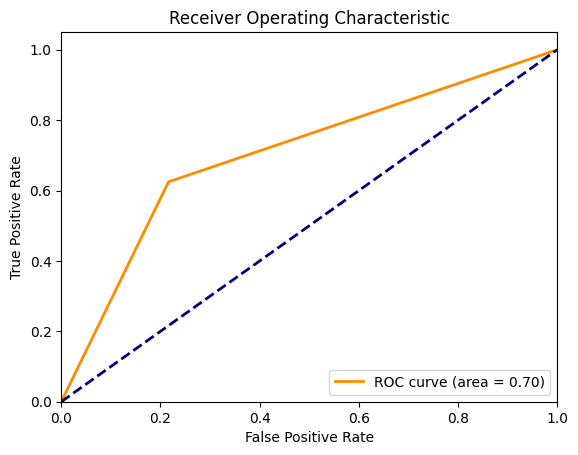

In [7]:
model1 = RandomForestClassifier(n_estimators=300, max_depth=20, min_samples_split=20, min_samples_leaf=5)

model1.fit(torch.cat((x_train1, s_train1), 1), y_train1)
y_pred1 = model1.predict(torch.cat((x_test, s_test), 1))


acc_1=accuracy_score(y_test, y_pred1)
F1_ensemble=f1_score(y_test, y_pred1)
fpr, tpr, _ = roc_curve(y_test, y_pred1)
roc_auc = auc(fpr, tpr)
print(f'Overall accuracy of random forest on imbalanced dataset: {acc_1}')
print(F1_ensemble)
# Plot ROC curve
plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange', lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

Overall accuracy of random forest on original dataset: 0.7281993204983013
F1 score: 0.6470588235294118


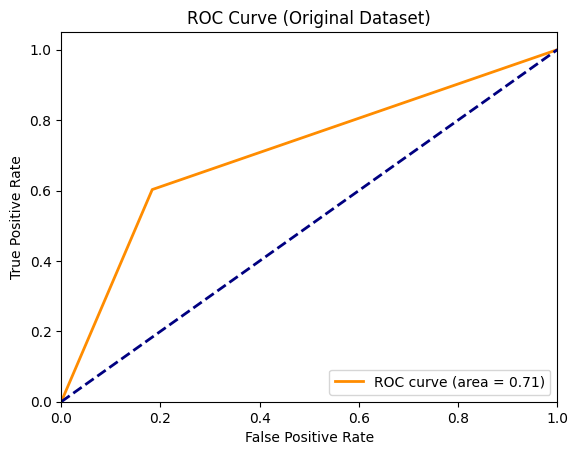

In [8]:
# Initialize and train the Random Forest model
RF_model = RandomForestClassifier(n_estimators=300, max_depth=20, min_samples_split=20, min_samples_leaf=5)
RF_model.fit(torch.cat((x_train0, s_train0), 1), y_train0)

# Make predictions and calculate metrics
y_pred = RF_model.predict(torch.cat((x_test, s_test), 1))
acc_1=accuracy_score(y_test, y_pred)
F1_ensemble=f1_score(y_test, y_pred)
fpr, tpr, _ = roc_curve(y_test, y_pred)
roc_auc = auc(fpr, tpr)

# Print metrics
print(f'Overall accuracy of random forest on original dataset: {acc_1}')
print(f'F1 score: {F1_ensemble}')

# Plot ROC curve
plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange', lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve (Original Dataset)')
plt.legend(loc="lower right")
plt.show()

#### Plot 1 UMAP of original training set

In [9]:
import os

if not os.path.exists("images"):
    os.mkdir("images")
if not os.path.exists("drive/MyDrive/MCRAGE"):
    os.mkdir("drive/MyDrive/MCRAGE")
if not os.path.exists("drive/MyDrive/MCRAGE/Model_Checkpoints"):
    os.mkdir("drive/MyDrive/MCRAGE/Model_Checkpoints")

In [10]:
trans =  UMAP(n_neighbors=30, metric='canberra', n_components=2, init='random', random_state=0).fit(x_train0)

print(s_train0.shape,y_train0.shape)
newlabs = s_train0.squeeze(-1) + 2 * y_train0

print(newlabs.shape)

fig_2d = px.scatter( x=trans.embedding_[:, 0], y=trans.embedding_[:, 1],
    color= newlabs.squeeze(-1).numpy().astype(str), labels={'color': 'Treatment'}, width=800, height=800,
    title='Manifold Projection of Original Dataset',
    color_discrete_sequence=["red","orange","green","blue"]
    )
fig_2d.show()
fig_2d.write_image("images/original_ds_manifold.png")

/usr/local/lib/python3.10/dist-packages/umap/umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


torch.Size([3529, 1]) torch.Size([3529])
torch.Size([3529])


#### Plot 2: UMAP of imbalanced dataset (manually created)

In [11]:
newlabs = EHR_train1.s + 2 * EHR_train1.y

newdata = trans.transform(EHR_train1.x)
fig_2d = px.scatter(x=newdata[:, 0], y=newdata[:, 1],
    color= newlabs.numpy().astype(str), labels={'color': 'Treatment'}, width=800, height=800,
    title='Manifold Projection of Imbalanced Dataset',
    color_discrete_sequence=["red","orange","green","blue"]
)
fig_2d.show()
fig_2d.write_image("images/imbalanced_ds_manifold.png")
# print(fig_2d)


In [12]:
def square_distance(x,y): return sum([(xi-yi)**2 for xi, yi in zip(x,y)])

A = EHR_train.x.numpy()
hull = ConvexHull(A)
hull_vertices_indices = hull.vertices
hull_vertices = A[hull_vertices_indices]
distances = np.linalg.norm(hull_vertices[:, np.newaxis] - hull_vertices, axis=-1)
diameter = np.max(distances)

# print("Convex Hull Vertices:\n", hull_vertices)
print("Diameter of M:", diameter)

Diameter of M: 16.289543


###Train DDPM

In [13]:
newlabs = torch.tensor(s_train + 2 * y_train) #SERIALIZED VARIABLE
#F, out : 0
#M, out : 1
#F, in : 2
#M, in : 3

print(newlabs)
print(newlabs.unique(return_counts=True))

tensor([[1., 1., 1.,  ..., 1., 3., 3.],
        [1., 1., 1.,  ..., 1., 3., 3.],
        [1., 1., 1.,  ..., 1., 3., 3.],
        ...,
        [1., 1., 1.,  ..., 1., 3., 3.],
        [1., 1., 1.,  ..., 1., 3., 3.],
        [1., 1., 1.,  ..., 1., 3., 3.]])


<ipython-input-13-2c858894f2f0>:1: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).



(tensor([0., 1., 2., 3.]), tensor([ 149930, 1702998,  109910, 1248426]))


In [20]:
class ResidualConvBlock(nn.Module):
    def __init__(
        self, in_channels: int, out_channels: int, is_res: bool = False
    ) -> None:
        super().__init__()
        '''
        Initializes a standard ResNet style convolutional block.

        Args:
            in_channels (int): Number of input channels.
            out_channels (int): Number of output channels.
            is_res (bool, optional): Whether to use residual connection. Defaults to False.
        '''
        self.same_channels = in_channels==out_channels
        self.is_res = is_res
        self.conv1 = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, 3, 1, 1),
            nn.BatchNorm2d(out_channels),
            nn.GELU(),
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(out_channels, out_channels, 3, 1, 1),
            nn.BatchNorm2d(out_channels),
            nn.GELU(),
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        '''
        Performs forward pass of the residual convolutional block.

        Args:
            x (torch.Tensor): Input tensor.

        Returns:
            torch.Tensor: Output tensor.
        '''
        if self.is_res:
            x1 = self.conv1(x)
            x2 = self.conv2(x1)
            # add on correct residual in case channels have increased
            if self.same_channels:
                out = x + x2
            else:
                out = x1 + x2
            return out
        else:
            x1 = self.conv1(x)
            x2 = self.conv2(x1)
            return x2

class UnetDown(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(UnetDown, self).__init__()
        '''
        Initializes a module for processing and downscaling image feature maps.

        Args:
            in_channels: Number of input channels.
            out_channels: Number of output channels.
        '''
        layers = [nn.Linear(in_channels, out_channels), nn.GELU()]
        self.model = nn.Sequential(*layers)

    def forward(self, x):
        '''
        Performs forward pass of the UnetDown module.

        Args:
            x (torch.Tensor): Input tensor.

        Returns:
            torch.Tensor: Output tensor.
        '''
        return self.model(x)


class UnetUp(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(UnetUp, self).__init__()
        '''
        Initializes a module for processing and upscaling image feature maps.

        Args:
            in_channels: Number of input channels.
            out_channels: Number of output channels.
        '''
        layers = [nn.Linear(in_channels, out_channels), nn.GELU()]

        self.model = nn.Sequential(*layers)

    def forward(self, x, skip):
        '''
        Performs forward pass of the UnetUp module.

        Args:
            x (torch.Tensor): Input tensor.
            skip (torch.Tensor): Skip connection tensor.

        Returns:
            torch.Tensor: Output tensor.
        '''
        x = torch.cat((x, skip), 1)
        # print(x.shape)
        x = self.model(x)
        return x

class EmbedFC(nn.Module):
    def __init__(self, input_dim, emb_dim):
        super(EmbedFC, self).__init__()
        '''
        Initializes a generic one layer fully connected neural network for embedding context/time information.

        Args:
            input_dim: Dimension of the input.
            emb_dim: Dimension of the embedding.
        '''
        self.input_dim = input_dim
        layers = [
            nn.Linear(input_dim, emb_dim),
            nn.GELU(),
            nn.Linear(emb_dim, emb_dim)
            # nn.GELU(),
            # nn.Linear(emb_dim, emb_dim)
        ]
        self.model = nn.Sequential(*layers)

    def forward(self, x):
        '''
        Performs forward pass of the EmbedFC module.

        Args:
            x (torch.Tensor): Input tensor.

        Returns:
            torch.Tensor: Output tensor.
        '''
        x = x.view(-1, self.input_dim)
        return self.model(x)


class ContextUnet(nn.Module):
    def __init__(self, in_channels, n_feat=1024, n_classes=10, dropout_prob=0.5):
        super(ContextUnet, self).__init__()
        self.in_channels = in_channels
        self.n_feat = n_feat
        self.n_classes = n_classes
        self.dropout_prob = dropout_prob

        self.down1 = UnetDown(n_feat, 64 * n_feat) #these used to be 8's

        self.timeembed1 = EmbedFC(1, 64 * n_feat)
        self.contextembed1 = EmbedFC(n_classes, 64 * n_feat)

        self.up0 = UnetUp(64 * n_feat, 64 * n_feat) #CHANGED FROM NN.LINEAR
        self.up1 = UnetUp(128 * n_feat, n_feat)

        self.dropout = nn.Dropout(p=self.dropout_prob)

    def forward(self, x, c, t, context_mask):
        down1 = self.down1(x)

        c = nn.functional.one_hot(c.long(), num_classes=self.n_classes).type(torch.float)

        context_mask = context_mask[:, None]
        context_mask = context_mask.repeat(1, self.n_classes)
        context_mask = (-1 * (1 - context_mask))
        c = c * context_mask

        cemb1 = self.contextembed1(c).view(-1, self.n_feat * 64)
        temb1 = self.timeembed1(t).view(-1, self.n_feat * 64)

        up1 = self.up0(down1)
        up2 = self.up1(cemb1 * up1 + temb1, down1)

        # Apply dropout
        up2 = self.dropout(up2)

        return up2

def ddpm_schedules(beta1, beta2, T):
    '''
    Returns pre-computed schedules for DDPM sampling, training process based on linear beta schedule.

    Args:
        beta1 (float): Beta1 value.
        beta2 (float): Beta2 value.
        T: T value.

    Returns:
        dict: Pre-computed schedules.
    '''
    assert beta1 < beta2 < 1.0, "beta1 and beta2 must be in (0, 1)"
    beta_t = (beta2 - beta1) * torch.arange(0, T + 1, dtype=torch.float32) / T + beta1
    sqrt_beta_t = torch.sqrt(beta_t)
    alpha_t = 1 - beta_t
    log_alpha_t = torch.log(alpha_t)
    alphabar_t = torch.cumsum(log_alpha_t, dim=0).exp()

    sqrtab = torch.sqrt(alphabar_t)
    oneover_sqrta = 1 / torch.sqrt(alpha_t)

    sqrtmab = torch.sqrt(1 - alphabar_t)
    mab_over_sqrtmab_inv = (1 - alpha_t) / sqrtmab

    return {
        "alpha_t": alpha_t,  # \alpha_t
        "oneover_sqrta": oneover_sqrta,  # 1/\sqrt{\alpha_t}
        "sqrt_beta_t": sqrt_beta_t,  # \sqrt{\beta_t}
        "alphabar_t": alphabar_t,  # \bar{\alpha_t}
        "sqrtab": sqrtab,  # \sqrt{\bar{\alpha_t}}
        "sqrtmab": sqrtmab,  # \sqrt{1-\bar{\alpha_t}}
        "mab_over_sqrtmab": mab_over_sqrtmab_inv,  # (1-\alpha_t)/\sqrt{1-\bar{\alpha_t}}
    }

def cosine_beta_schedule(timesteps, s = 0.008):
    '''
    Generate a cosine schedule for beta values.

    Args:
        timesteps (int): Number of timesteps.
        s (float, optional): Scaling factor. Defaults to 0.008.

    Returns:
        torch.Tensor: Cosine beta schedule.
    '''
    steps = timesteps + 1
    x = torch.linspace(0, timesteps, steps, dtype = torch.float64)
    alphas_cumprod = torch.cos(((x / timesteps) + s) / (1 + s) * math.pi * 0.5) ** 2
    alphas_cumprod = alphas_cumprod / alphas_cumprod[0]
    betas = 1 - (alphas_cumprod[1:] / alphas_cumprod[:-1])
    return torch.clip(betas, 0, 0.999)


class DDPM(nn.Module):
    def __init__(self, nn_model, betas, n_T, device, drop_prob=0.1):
        '''
        Initializes a Deep Denoising Diffusion Probabilistic Model (DDPM).

        Args:
            nn_model (nn.Module): Neural network model.
            betas (tuple): Beta values.
            n_T (int): Number of timesteps.
            device (str): Device to run the model on.
            drop_prob (float, optional): Dropout probability. Defaults to 0.1.
        '''
        super(DDPM, self).__init__()
        self.nn_model = nn_model.to(device)
        # register_buffer allows accessing dictionary produced by ddpm_schedules
        # e.g. can access self.sqrtab later
        for k, v in ddpm_schedules(betas[0], betas[1], n_T).items():
            self.register_buffer(k, v)

        self.n_T = n_T
        self.device = device
        self.drop_prob = drop_prob
        self.loss_mse = nn.MSELoss()

    def forward(self, x, c):
        '''
        Forward pass of the DDPM model used in training.

        Args:
            x (torch.Tensor): Input tensor.
            c (torch.Tensor): Context tensor.

        Returns:
            torch.Tensor: Loss tensor.
        '''

        _ts = torch.randint(1, self.n_T+1, (x.shape[0],)).to(self.device)  # t ~ Uniform(0, n_T)
        noise = torch.randn_like(x)  # eps ~ N(0, 1)
        x_t = (
            self.sqrtab[_ts, None] * x
            + self.sqrtmab[_ts, None] * noise
        )

        # Dropout context with some probability
        context_mask = torch.bernoulli(torch.zeros_like(c) + self.drop_prob).to(self.device)

        # Predict the "error term" from this x_t using the neural network
        predicted_noise = self.nn_model(x_t, c, _ts / self.n_T, context_mask)

        # Compute ELBO loss, which is a combination of reconstruction loss and KL divergence
        reconstruction_loss = F.mse_loss(predicted_noise, noise, reduction='mean')
        kl_divergence = 0.5 * torch.mean(torch.sum(self.sqrtmab[_ts, None]**2 - 1 - self.sqrtab[_ts, None]**2, dim=1))

        # ELBO loss is the sum of reconstruction loss and KL divergence
        elbo_loss = reconstruction_loss + kl_divergence

        return elbo_loss

    def sample(self, n_sample, size, device, label= 2, guide_w = 3.0):
        '''
        Sample from the DDPM model.

        Args:
            n_sample (int): Number of samples.
            size (tuple): Size of the samples.
            device (str): Device to run the model on.
            label (int, optional): Label value. Defaults to 2.
            guide_w (float, optional): Guidance scale. Defaults to 5.0.

        Returns:
            torch.Tensor: Sampled tensor.
            numpy.ndarray: Generated steps.
        '''
        # we follow the guidance sampling scheme described in 'Classifier-Free Diffusion Guidance'
        # to make the fwd passes efficient, we concat two versions of the dataset,
        # one with context_mask=0 and the other context_mask=1
        # we then mix the outputs with the guidance scale, w
        # where w>0 means more guidance

        x_i = torch.randn(n_sample, *size).to(device)  # x_T ~ N(0, 1), sample initial noise

        c_i = torch.tensor(label).to(device)
        c_i = c_i.repeat(int(n_sample/c_i.shape[0]))

        # don't drop context at test time
        context_mask = torch.zeros_like(c_i).to(device)

        # double the batch
        c_i = c_i.repeat(2)
        context_mask = context_mask.repeat(2)
        context_mask[n_sample:] = 1. # makes second half of batch context free

        x_i_store = [] # keep track of generated steps in case want to plot something
        #print()
        for i in range(self.n_T, 0, -1):
            #print(f'sampling timestep {i}',end='\r')
            t_is = torch.tensor([i / self.n_T]).to(device)
            t_is = t_is.repeat(n_sample,1)

            # double batch
            x_i = x_i.repeat(2,1)
            t_is = t_is.repeat(2,1)

            z = torch.randn(n_sample, *size).to(device) if i > 1 else 0

            # split predictions and compute weighting
            eps = self.nn_model(x_i, c_i, t_is, context_mask)
            eps1 = eps[:n_sample]
            eps2 = eps[n_sample:]
            eps = (1+guide_w)*eps1 - guide_w*eps2
            x_i = x_i[:n_sample]
            x_i = (
                self.oneover_sqrta[i] * (x_i - eps * self.mab_over_sqrtmab[i])
                + self.sqrt_beta_t[i] * z
            )
            if i%20==0 or i==self.n_T or i<8:
                x_i_store.append(x_i.detach().cpu().numpy())

        x_i_store = np.array(x_i_store)
        return x_i, x_i_store

def evaluate_model(ddpm, features, device, x_train, s_train, y_train, x_test, s_test, y_test):
    ddpm.eval()

    newlabs = s_train + 2 * y_train.unsqueeze(1)
    labels, counts = newlabs.unique(return_counts=True)

    K = int(max(counts))

    with torch.no_grad():
        n_sample = (torch.tensor(K).repeat(1,4) - counts.cpu()).numpy().ravel()
        # print(n_sample)
        x_gen0, x_gen0_store = ddpm.sample(n_sample[0], (9,), device, label=[0], guide_w=3)
        x_gen1, x_gen1_store = ddpm.sample(n_sample[1], (9,), device, label=[1], guide_w=3)
        x_gen2, x_gen2_store = ddpm.sample(n_sample[2], (9,), device, label=[2], guide_w=3)
        x_gen3, x_gen3_store = ddpm.sample(n_sample[3], (9,), device, label=[3], guide_w=3)

    x_train = torch.vstack([EHR_train.x, torch.cat((x_gen0,x_gen1,x_gen2,x_gen3), 0).cpu().cpu()])
    s_train = torch.concatenate((EHR_train.s, torch.tensor(0).repeat(n_sample[0]), torch.tensor(1).repeat(n_sample[1]),
                                torch.tensor(0).repeat(n_sample[2]), torch.tensor(1).repeat(n_sample[3])))
    y_train = torch.concatenate((EHR_train.y, torch.tensor(0).repeat(n_sample[0]), torch.tensor(0).repeat(n_sample[1]),
                                torch.tensor(1).repeat(n_sample[2]), torch.tensor(1).repeat(n_sample[3])))

    # Train random forest classifier on the augmented dataset
    model = RandomForestClassifier(n_estimators=300, max_depth=20, min_samples_split=20, min_samples_leaf=5)
    model.fit(torch.cat((x_train, s_train.unsqueeze(-1)), 1),y_train)

    # Predict using the trained model
    y_pred = model.predict(torch.cat((x_test, s_test), 1))

    # Calculate F1 score
    f1_ensemble = f1_score(y_test, y_pred, average='weighted')

    return f1_ensemble

def ema(source, target, decay):
    '''
    Applies Exponential Moving Average (EMA) to update the target model's parameters based on the source model's parameters.

    Args:
        source (nn.Module): Source model from which the parameters are copied.
        target (nn.Module): Target model to update with EMA.
        decay (float): Decay factor for the EMA update. Controls the contribution of the source model's parameters.

    Returns:
        None
    '''
    source_dict = source.state_dict()
    target_dict = target.state_dict()

    for key in source_dict.keys():
        target_dict[key].data.copy_(
            target_dict[key].data * decay +
            source_dict[key].data * (1 - decay))

In [21]:
# EXPERIMENT DUPLICATE

n_epoch = 10000
log_freq = int(n_epoch/100)
batch_size = 128
n_T = 35
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
n_classes = 4
n_feat = 9

# Define sequences of hyperparameters
learning_rates = np.logspace(-4.5, -3.9, num=5)
dropout_probs = np.linspace(0.7, 0.8, num=5)
# bta = np.logspace(-3, -.5, num=5)

# learning_rates = [1e-03]
# learning_rates = [1e-2]
dropout_probs = [.7]
bta = [2e-1]
beta_values = [(10**(-10), b) for b in bta]

best_hyperparameters = {}
best_accuracy = 0.0

dataloader = torch.utils.data.DataLoader(EHR_train, batch_size=batch_size, drop_last=True, shuffle=True)
j = 0

# Perform grid search
for learning_rate, dropout_prob, beta in product(learning_rates, dropout_probs, beta_values):
    j += 1
    best_acc_mod = 0.0
    modname = f"CDDPM_Setting-{j}"
    filename = os.path.join("/content/drive/MyDrive/MCRAGE/Model_Checkpoints", modname)

    ddpm = DDPM(nn_model=ContextUnet(in_channels=1, n_feat=n_feat, n_classes=4), betas=beta, n_T=n_T, device=device, drop_prob=dropout_prob)
    ddpm.to(device)
    ddpm_ema = copy.deepcopy(ddpm)

    optimizer = torch.optim.Adam(ddpm.parameters(), learning_rate, weight_decay=0.0001)

    scheduler = StepLR(optimizer, step_size=400, gamma=0.97)

    beta1, beta2 = beta

    print(f"Hyperparameters {j}:\n"
          f"  Learning Rate: {learning_rate:.6f}\n"
          f"  Dropout: {dropout_prob:.2f}\n"
          f"  Beta1: {beta1:.6f}\n"
          f"  Beta2: {beta2:.6f}\n")

    # Update hyperparameters
    lrate = learning_rate
    ddpm.drop_prob = dropout_prob
    ddpm.betas = (beta1, beta2)

    # Reinitialize optimizer and scheduler with updated learning rate
    optimizer = torch.optim.Adam(ddpm.parameters(), lrate, weight_decay=0.0001)
    scheduler = StepLR(optimizer, step_size=100, gamma=0.97)

    # Train the model for 2000 epochs
    loss_ema = True
    ddpm.train()

    for epoch in range(n_epoch):
        for i, (x, s, y) in enumerate(dataloader):
            optimizer.zero_grad()
            x = x.to(device)
            s = s.to(device)
            y = y.to(device)
            z = s + 2 * y

            # Forward pass with dropout enabled during training
            loss = ddpm(x, z)

            loss.backward()

            ema(ddpm, ddpm_ema, 0.95)
            if loss_ema is None:
                loss_ema = loss.item()
            else:
                loss_ema = 0.95 * loss_ema + 0.05 * loss.item()

            optimizer.step()
            scheduler.step()

            if epoch % log_freq == 0 and i == 0:
                print(epoch, " loss: ", loss_ema, "lr: ", scheduler.get_last_lr()[0])
                accuracy = evaluate_model(ddpm, features, device, x_train, s_train, y_train, x_val, s_val, y_val)

                if accuracy > best_acc_mod:
                  best_acc_mod = accuracy
                  torch.save(ddpm.state_dict(), filename + "_best.pth")
                  print("new best model!")


    torch.save(ddpm.state_dict(), filename + "_last.pth")
    accuracy = evaluate_model(ddpm, features, device, x_train, s_train, y_train, x_test, s_test, y_test)
    print(best_acc_mod)

    if best_acc_mod > best_accuracy:
      best_accuracy = best_acc_mod
      best_hyperparameters = {
          'learning_rate' : learning_rate,
          'dropout_prob': dropout_prob,
          'beta1' : beta1,
          'beta2' : beta2
      }
      print(f"best setting so far: {j}")
      best_setting = j


print("Best hyperparameters:", best_hyperparameters)
print("Best accuracy:", best_accuracy)

# Perform a training run with the best hyperparameters
best_learning_rate = best_hyperparameters['learning_rate']
best_dropout_prob = best_hyperparameters['dropout_prob']
best_beta1 = best_hyperparameters['beta1']
best_beta2 = best_hyperparameters['beta2']

# Update hyperparameters with the best values
lrate = best_learning_rate
ddpm.drop_prob = best_dropout_prob
ddpm.betas = (best_beta1, best_beta2)

# After training, load the model and set to evaluation mode to disable dropout

modname = f"CDDPM_Setting-{best_setting}"
filename = os.path.join("/content/drive/MyDrive/MCRAGE/Model_Checkpoints", modname + "_best.pth")

ddpm.load_state_dict(torch.load(filename))

ddpm.eval()

evaluate_model(ddpm, features, device, x_train, s_train, y_train, x_test, s_test, y_test)

Hyperparameters 1:
  Learning Rate: 0.001000
  Dropout: 0.70
  Beta1: 0.000000
  Beta2: 0.200000

0  loss:  0.5332123041152954 lr:  0.001
new best model!
100  loss:  0.2134726643562317 lr:  0.0006528362774606073
200  loss:  0.27417153120040894 lr:  0.00042619520516862307
300  loss:  0.2611347734928131 lr:  0.00027823569121384375
400  loss:  0.22012534737586975 lr:  0.00018164235290872477
500  loss:  0.3039149045944214 lr:  0.00011858271750211782
new best model!
600  loss:  0.2022186517715454 lr:  7.74150998652454e-05
700  loss:  0.2807692885398865 lr:  5.0539385615267973e-05
new best model!
800  loss:  0.2465400993824005 lr:  3.299394437021771e-05
900  loss:  0.2301490306854248 lr:  2.1539643821395283e-05


KeyboardInterrupt: 

###Generate Samples and Visualize Distribution of Augmented Sample Features

In [ ]:
#!pip install pandas==1.3.3
newlabs = s_train + 2 * y_train.unsqueeze(1)
print(newlabs.shape)

labels, counts = newlabs.unique(return_counts=True) #value_counts()
print(labels, counts)

K = int(max(counts))

# generate synthetic samples
ddpm.eval()
with torch.no_grad():
    n_sample = (torch.tensor(K).repeat(1,4) - counts.cpu()).numpy().ravel()
    print(n_sample)
    x_gen0, x_gen0_store = ddpm.sample(n_sample[0], (9,), device, label=[0], guide_w=3)
    x_gen1, x_gen1_store = ddpm.sample(n_sample[1], (9,), device, label=[1], guide_w=3)
    x_gen2, x_gen2_store = ddpm.sample(n_sample[2], (9,), device, label=[2], guide_w=3)
    x_gen3, x_gen3_store = ddpm.sample(n_sample[3], (9,), device, label=[3], guide_w=3)

x_train = torch.vstack([EHR_train.x, torch.cat((x_gen0,x_gen1,x_gen2,x_gen3), 0).cpu().cpu()])
s_train = torch.concatenate((EHR_train.s, torch.tensor(0).repeat(n_sample[0]), torch.tensor(1).repeat(n_sample[1]),
                             torch.tensor(0).repeat(n_sample[2]), torch.tensor(1).repeat(n_sample[3])))
y_train = torch.concatenate((EHR_train.y, torch.tensor(0).repeat(n_sample[0]), torch.tensor(0).repeat(n_sample[1]),
                             torch.tensor(1).repeat(n_sample[2]), torch.tensor(1).repeat(n_sample[3])))


newlabs = s_train + 2 * y_train
labels, counts = newlabs.unique(return_counts=True) #value_counts()
print(labels, counts)

In [ ]:
print(s_train.shape, y_train.shape)

In [ ]:
# Plot pie chart of augmented dataset
def func(pct, allvals):
    absolute = int(pct/100.* np.sum(allvals))
    return "{:.1f}%\n({:d} g)".format(pct, absolute)
labels, counts = torch.unique(y_train, return_counts = True )
plt.pie(counts, labels=['Outpatient Care', 'Inpatient Care'], autopct='%1.1f%%', colors=['#66CDAA','orange'])
plt.title('Augmented EHR Dataset Composition')
plt.savefig("images/augmented_ds_pie.png")

train_labels, train_counts = EHR_train.s.unique(return_counts=True)
print("train s:", train_labels, train_counts)

train_labels, train_counts = EHR_train.y.unique(return_counts=True)
print("train y:", train_labels, train_counts)

In [ ]:
# Train and test random forest classifier on augmented dataset
model1 = RandomForestClassifier(n_estimators=300, max_depth=20, min_samples_split=20, min_samples_leaf=5)
model1.fit(torch.cat((x_train, s_train.unsqueeze(-1)), 1),y_train)
y_pred1 = model1.predict(torch.cat((x_test, s_test), 1))

acc_1= accuracy_score(y_test, y_pred1)
F1_ensemble= f1_score(y_test, y_pred1)
fpr, tpr, __ = roc_curve(y_test, y_pred1)
roc_auc = auc(fpr, tpr)

print(f' Overall accuracy of random forest classifier trained on augmented dataset {accuracy_score(y_test, y_pred1)}')
print(F1_ensemble)
# Plot ROC curve
plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange', lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Random Forest trained on Augmented Dataset ROC Curve')
plt.legend(loc="lower right")
plt.show()

### Visualize the generated samples by class

In [ ]:
ddpm.eval()

# Generate 1000 samples of each class to check feature distribution
with torch.no_grad():
    n_sample = 1000
    x_gen, x_gen_store = ddpm.sample(n_sample, (9,), device, label=[0], guide_w=3)
df0 = pd.DataFrame(x_gen.cpu().numpy(), columns=features)

with torch.no_grad():
    n_sample = 1000
    x_gen, x_gen_store = ddpm.sample(n_sample, (9,), device, label=[1], guide_w=3)
df1 = pd.DataFrame(x_gen.cpu().numpy(), columns=features)

with torch.no_grad():
    n_sample = 1000
    x_gen, x_gen_store = ddpm.sample(n_sample, (9,), device, label=[2], guide_w=3)
df2 = pd.DataFrame(x_gen.cpu().numpy(), columns=features)

with torch.no_grad():
    n_sample = 1000
    x_gen, x_gen_store = ddpm.sample(n_sample, (9,), device, label=[3], guide_w=3)
df3 = pd.DataFrame(x_gen.cpu().numpy(), columns=features)

# Calculate new labels based on s_test and y_test
newlabs_test = torch.Tensor(s_test + 2 * y_test)

# Define x0_test for the test data using the new labels
x0_test = pd.DataFrame(EHR_test.x.cpu().numpy(), columns=features)
x0_test = x0_test.iloc[(newlabs_test == 0).nonzero(as_tuple=True)[0], :]

# Define x1_test for the test data using the new labels
x1_test = pd.DataFrame(EHR_test.x.cpu().numpy(), columns=features)
x1_test = x1_test.iloc[(newlabs_test == 1).nonzero(as_tuple=True)[0], :]

# Define x2 for the test data using the new labels
x2_test = pd.DataFrame(EHR_test.x.cpu().numpy(), columns=features)
x2_test = x2_test.iloc[(newlabs_test == 2).nonzero(as_tuple=True)[0], :]

# Define x3 for the test data using the new labels
x3_test = pd.DataFrame(EHR_test.x.cpu().numpy(), columns=features)
x3_test = x3_test.iloc[(newlabs_test == 3).nonzero(as_tuple=True)[0], :]

fig, axes = plt.subplots(9, 1, figsize=(13, 35))
plt.subplots_adjust(hspace=0.5)  # Add vertical spacing

# Loop through each feature
for i, c in enumerate(features):
    # KDE plots for generated and original data
    df3[[c]].plot(kind='kde', color='blue', linestyle='--', ax=axes[i])
    df2[[c]].plot(kind='kde', color='green', linestyle='--', ax=axes[i])
    df1[[c]].plot(kind='kde', color='orange', linestyle='--', ax=axes[i])
    df0[[c]].plot(kind='kde', color='red', linestyle='--', ax=axes[i])

    x3_test[[c]].plot(kind='kde', color='blue', linestyle='-', ax=axes[i])
    x2_test[[c]].plot(kind='kde', color='green', linestyle='-', ax=axes[i])
    x1_test[[c]].plot(kind='kde', color='orange', linestyle='-', ax=axes[i])
    x0_test[[c]].plot(kind='kde', color='red', linestyle='-', ax=axes[i])

    axes[i].legend([f'{c} - Generated (M, Out)', f'{c} - Generated (F, Out)',
                    f'{c} - Generated (M, In)', f'{c} - Generated (F, In)',
                    f'{c} - Original (M, Out)', f'{c} - Original (F, Out)',
                    f'{c} - Original (M, Out)', f'{c} - Original (F, In)'])
    axes[i].set_title(f'Generated and Original Comparison of {c} by Class')

    # Set x-axis limits for better zoom level
    axes[i].set_xlim([-10, 10])  # Adjust the limits as needed

# Show the plot
plt.show()
plt.savefig("images/histogram.png")

#### Plot 3: UMAP of datasets after augmentation

In [ ]:
# manifold visualization of augmented dataset
newlabs = s_train + 2 * y_train

newdata = trans.transform(x_train)
fig_2d = px.scatter(x=newdata[:, 0], y=newdata[:, 1],
    color= newlabs.squeeze(-1).numpy().astype(str), labels={'color': 'Treatment'}, width=800, height=800,
    title='Manifold Projection of Augmented Dataset',
    color_discrete_sequence=["red","orange","green","blue"]
)
fig_2d.show()

### Testing SMOTE

In [ ]:
# SMOTE implemented w/sklearn package
import torch.utils.data as data_utils
from imblearn.over_sampling import SMOTE
from torch.utils.data import Dataset

smote = SMOTE()
newlabs = EHR_train1.s + 2 * EHR_train1.y

X, labs = smote.fit_resample(EHR_train1.x.detach().numpy(), newlabs.detach().numpy()) # smote the dataset (ONLY training set)
X_tensor = torch.from_numpy(X) # convert smoted data to tensor
s_tensor = torch.remainder(torch.from_numpy(labs), 2)
y_tensor = (torch.from_numpy(labs) - s_tensor) / 2 # convert labels data to tensor

EHR_train1.x = X_tensor
EHR_train1.s = s_tensor
EHR_train1.y = y_tensor

train_labels, train_counts = EHR_train1.s.unique(return_counts=True)
print("train s:", train_labels, train_counts)

train_labels, train_counts = EHR_train1.y.unique(return_counts=True)
print("train y:", train_labels, train_counts)

# print(s_tensor, y_tensor)

In [ ]:
newdata = trans.transform(EHR_train1.x)
newlabs = EHR_train1.s + 2 * EHR_train1.y

fig_2d = px.scatter(x=newdata[:, 0], y=newdata[:, 1],
    color= newlabs.squeeze(-1).numpy().astype(str), labels={'color': 'Treatment'}, width=800, height=800,
    title='Manifold Projection of Augmented Dataset',
    color_discrete_sequence=["red","orange","green","blue"]
)
fig_2d.show()

In [ ]:
# Plot pie chart of SMOTED dataset
def func(pct, allvals):
    absolute = int(pct/100.*np.sum(allvals))
    return "{:.1f}%\n({:d} g)".format(pct, absolute)
v, c = torch.unique(EHR_train1.y, return_counts = True )
plt.pie(c, labels=['Outpatient Care', 'Inpatient Care'], autopct='%1.1f%%', colors=['#66CDAA','orange'])
plt.title('SMOTED EHR Dataset Composition')
plt.savefig("images/augmented_ds_pie.png")


In [ ]:
# Train random forest classifier on SMOTED dataset
x_train = EHR_train1.x
y_train = EHR_train1.y
model1 = RandomForestClassifier(n_estimators=300, max_depth=20, min_samples_split=20, min_samples_leaf=5)
model1.fit(x_train,y_train)
y_pred1 = model1.predict(x_test)
acc_1=accuracy_score(y_test, y_pred1)
F1_ensemble=f1_score(y_test, y_pred1)
fpr, tpr, _ = roc_curve(y_test, y_pred1)
roc_auc = auc(fpr, tpr)
print(f' Overall accuracy of random forest classifier trained on SMOTED dataset {acc_1}')
print(F1_ensemble)
# Plot ROC curve
plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange', lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for SMOTED dataset')
plt.legend(loc="lower right")
plt.show()
